In [1]:
#ensure packages are in the right path
import sys
sys.path.append("/usr/local/lib/python3.6/site-packages")

In [2]:
#some necessary imports

import numpy as np
import keras
from keras.preprocessing import image
from keras.applications import resnet50
from keras.applications import inception_resnet_v2
import scipy
import os
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Conv3D

from keras.models import Model

from keras.utils import plot_model
from IPython.display import Image
import tensorflow as tf

import sklearn
import pprint
import matplotlib.pyplot as plt
import pickle
from utils_SimCONV import * #useful utility functions included in this package 

/Users/jack/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#  SimCONV
## a simple first attempt at a binary classifier using Convolutional networks

In [ ]:
#Idea of this model: Simple with large convolution so that there is minimal small feature detections, and 
#few layers for ease of training.
training_data='Data_set1/Training'
test_data='Data_set1/Test'
input_shape=(256,256,3)

SimCONV= Sequential()



conv_1=Conv2D(16, (9,9), padding='same', input_shape=input_shape, activation='relu')


conv_2=Conv2D(32, (7,7), padding='valid', input_shape=input_shape, activation='relu')

#pool=MaxPooling2D(pool_size=(2,2))
# we won't pool for this first test

flat=Flatten()

fc=Dense(units=128, activation='relu')
out=Dense(units=1, activation='sigmoid')

#add all of the layers in order
SimCONV.add(conv_1)
SimCONV.add(conv_2)
#SimCONV.add(pool)
SimCONV.add(flat)
SimCONV.add(fc)
SimCONV.add(out)



train_datagen=image.ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip= True)
test_datagen=image.ImageDataGenerator(rescale=1/255)
train_set=train_datagen.flow_from_directory(training_data, target_size=(256,256), batch_size=32, class_mode='binary')
test_set=test_datagen.flow_from_directory(test_data, target_size=(256,256), batch_size=32, class_mode="binary")

SimCONV.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
SimCONV.fit_generator(train_set,epochs=20, validation_data=test_set)


#this took way too long, and did not seem to train

In [ ]:
# Significantly reduced the resolution and used 2 very large convolutional networks
training_data='Data_set1/Training'
test_data='Data_set1/Test'
input_shape=(64,64,3) #higher resolution, 4 times more pixels 

SimCONV_3= Sequential()



conv_1=Conv2D(16, (7,7), padding='same', input_shape=input_shape, activation='relu')


conv_2=Conv2D(16, (7,7), padding='same', input_shape=input_shape, activation='relu') #Now there is no down sampling 
                                                                        
#pool=MaxPooling2D(pool_size=(2,2))
# we won't pool for this first test

flat=Flatten()

fc=Dense(units=128, activation='relu')
out=Dense(units=1, activation='sigmoid')

#add all of the layers in order
SimCONV_3.add(conv_1)
SimCONV_3.add(conv_2)
#SimCONV.add(pool)
SimCONV_3.add(flat)
SimCONV_3.add(fc)
SimCONV_3.add(out)


#Training without image manipulation
train_datagen=image.ImageDataGenerator(rescale=1/255)
test_datagen=image.ImageDataGenerator(rescale=1/255)
train_set=train_datagen.flow_from_directory(training_data, target_size=(64,64), batch_size=32, class_mode='binary')
test_set=test_datagen.flow_from_directory(test_data, target_size=(64,64), batch_size=90, class_mode="binary")

#sgd_nest=keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0001, nesterov=True);
SimCONV_3.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy']) 
history_training_1=SimCONV_3.fit_generator(train_set,epochs=20, validation_data=test_set)


# now we will add aberations to the data
train_datagen=image.ImageDataGenerator(rescale=1/255, shear_range=0.2, zoom_range=0.2, horizontal_flip= True)
train_set=train_datagen.flow_from_directory(training_data, target_size=(64,64), batch_size=32, class_mode='binary')
test_set=test_datagen.flow_from_directory(test_data, target_size=(64,64), batch_size=90, class_mode="binary")

history_training_2=SimCONV_3.fit_generator(train_set,epochs=20, validation_data=test_set)

#append the training histories
history_1=history_training_1.history
history_2=history_training_2.history
history_full=dict()
for key in history_1.keys():
        history_full[key]=history_1[key]+history_2[key]
    
version='1.3'
date='6-29'
#saving model and history
SimCONV_3.save('models/SimCONV_'+version+'_'+date+'.hdf5')
save_dict('Logs/SimCONV_1.3',history_full)

# Validation 

In [3]:
#this is the test set that we will use to test the models
test_data='Data_set1/Test'   #path to our testing directory 
test_datagen=image.ImageDataGenerator(rescale=1/255)
test_set=test_datagen.flow_from_directory(test_data, target_size=(64,64), batch_size=90, class_mode="binary")

Found 90 images belonging to 2 classes.


In [4]:
#load previous model
model=keras.models.load_model('models_LFS/SimCONV_1.3_6-29.hdf5')

## Confusion Matrix

[[31 14]
 [ 5 40]]


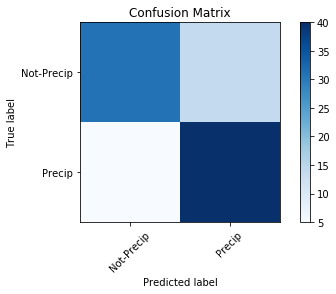

In [6]:
#now that we have created predictions, and a boolean classification...
model=keras.models.load_model('models_LFS/SimCONV_1.3_6-29.hdf5')
data=test_set[0][0]   #extract ndarrays of data from generator
labels=test_set[0][1] #extract expected labels from generator
classes=dict_to_list(test_set.class_indices) 

print(plot_confusion_matrix(model, data, labels, classes))
plt.savefig("images/CM_SimCONV")

## Misclassified Images 

In [7]:
model=keras.models.load_model('models_LFS/SimCONV_1.3_6-29.hdf5')
data=test_set[0][0]   #extract img arrays
labels=test_set[0][1] #extract expected labels from the test set

MisClass_NonPrecip,MisClass_Precip,conf=test_model(data,labels,model)



In [11]:
MisClass_Precip

[5, 16, 63, 71, 87]

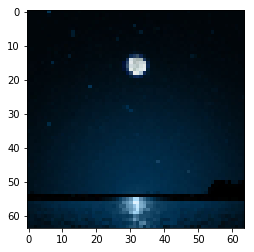

[0.96388984]


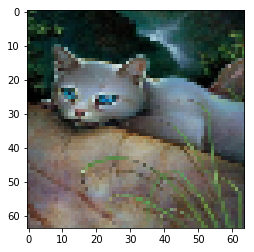

[0.95546925]


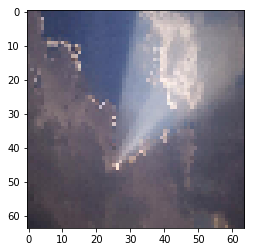

[0.6788292]


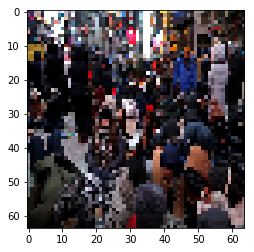

[0.91340965]


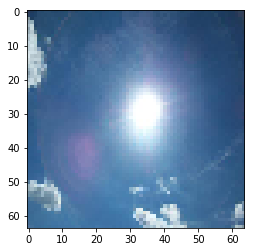

[0.9088753]


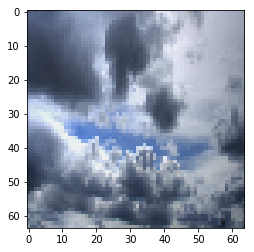

[0.8830734]


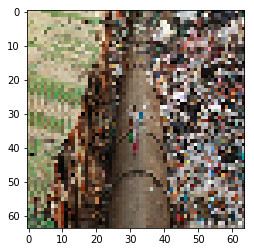

[0.931903]


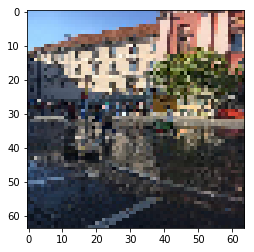

[0.87870026]


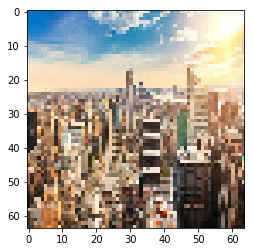

[0.5781859]


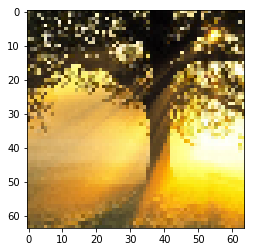

[0.94747925]


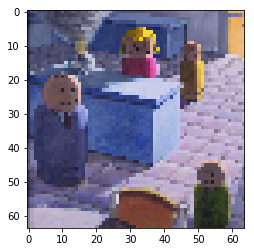

[0.95086616]


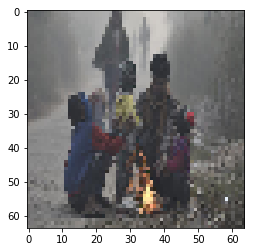

[0.7456679]


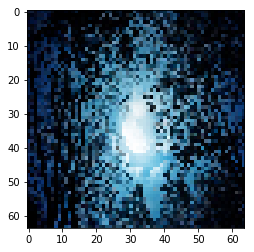

[0.5744658]


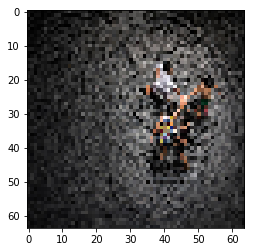

[0.68082476]


<Figure size 432x288 with 0 Axes>

In [8]:
for ind in MisClass_NonPrecip: #non-precipitation images, classified as precipiation
    display_NParray(data[ind])
    plt.figure()
    print(conf[ind]) #print percent confidence,

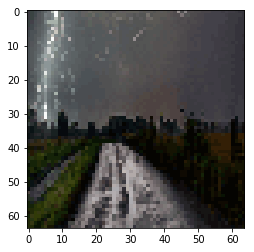

[0.999362]


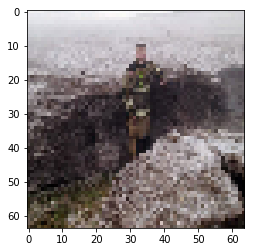

[0.82836413]


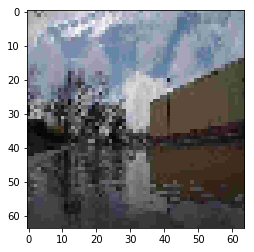

[0.96937335]


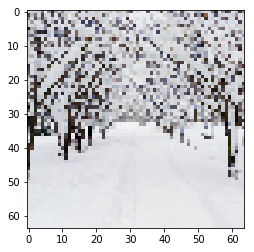

[0.5855251]


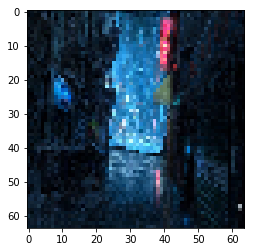

[0.6840731]


<Figure size 432x288 with 0 Axes>

In [9]:
for ind in MisClass_Precip: #precipitation images, classified as non-precipiation
    display_NParray(data[ind])
    plt.figure()
    print(1-conf[ind]) #here precipitation is class 0, and so 

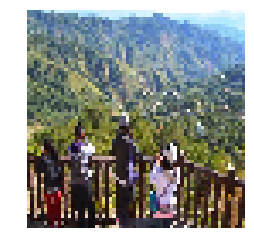

In [27]:
plt.figure()
plt.axis('off')
plt.imshow(data[12], interpolation='nearest')
plt.savefig("images/example_pic")

In [ ]:
#From a human perspecitive, these images seem too pixelated, so lets see if we can get better results by upping the 
#resolution and then applying larger filters, to recognize about the same size, perhaps we can get better definiition
# on the features

# Training loss and Accuracy

In [8]:
history_full=pickle.load(open("Logs/SimCONV_1.3",'rb')) #read dictionary from Logs

In [27]:
fig.subplots_adjust(hspace=1)

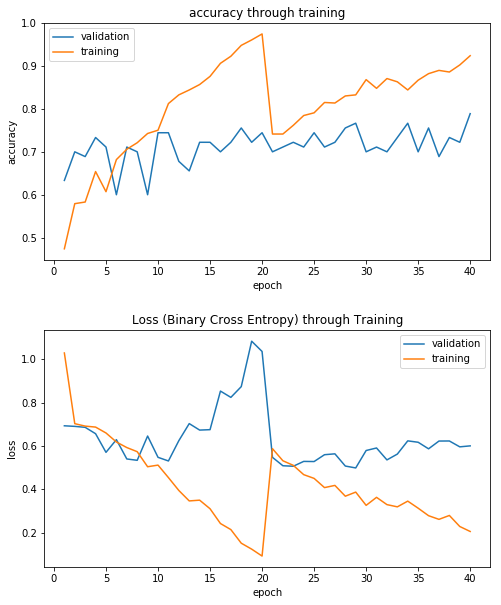

In [39]:
x=range(1,41)
fig=plt.figure(figsize=(8,10))
fig.subplots_adjust(hspace=.3)
plt.subplot(211)
plt.plot(x,history_full['val_acc'],x,history_full['acc'])
plt.title("accuracy through training")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['validation','training'])

plt.subplot(212)
plt.plot(x,history_full['val_loss'],x,history_full['loss'])
plt.title("Loss (Binary Cross Entropy) through Training")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['validation','training'])

plt.savefig("images/Training_logs_SimCONV.jpg")

In [14]:
val_acc=np.array((history_full['val_acc']))

In [15]:
print('validation mean accuracy over training:',val_acc.mean())
print('maximum accuracy over training:', val_acc.max())
print('most recent accuracy:',val_acc[-1])

validation mean accuracy over training: 0.7133333325386048
maximum accuracy over training: 0.7888888716697693
most recent accuracy: 0.7888888716697693


# Visualizing Convolutional Layers


In [3]:
model=keras.models.load_model('models/SimCONV_1.3_6-29.hdf5')

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 16)        2368      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        12560     
_________________________________________________________________
flatten_4 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 8,403,793
Trainable params: 8,403,793
Non-trainable params: 0
_________________________________________________________________


In [43]:
'''Visualization of the filters of VGG16, via gradient ascent in input space.
This script can run on CPU in a few minutes.
Results example: http://i.imgur.com/4nj4KjN.jpg
'''
from __future__ import print_function

import numpy as np
import time
from keras.preprocessing.image import save_img
from keras.applications import vgg16
from keras import backend as K

# dimensions of the generated pictures for each filter.
img_width = 128
img_height = 128

# the name of the layer we want to visualize
layer_name = 'conv2d_8'

# util function to convert a tensor into a valid image


def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    if K.image_data_format() == 'channels_first':
        x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x


# build the VGG16 network with ImageNet weights
model = keras.models.load_model('models_LFS/SimCONV_1.3_6-29.hdf5')
print('Model loaded.')

model.summary()

# this is the placeholder for the input images
input_img = model.input

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())


kept_filters = []
for filter_index in range(16):
    # TODO: automatically infer the filters
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
    if K.image_data_format() == 'channels_first':
        loss = K.mean(layer_output[:, filter_index, :, :])
    else:
        loss = K.mean(layer_output[:, :, :, filter_index])

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    if K.image_data_format() == 'channels_first':
        input_img_data = np.random.random((1, 3, img_width, img_height))
    else:
        input_img_data = np.random.random((1, img_width, img_height, 3))
    input_img_data = (input_img_data - 0.5) * 20 + 128

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > -1000:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

#we will stich the best 64 filters on a 8 x 8 grid.
n = 3

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
save_img('stitched_filters_%dx%d.png' % (n, n), stitched_filters)

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 64, 64, 16)        2368      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        12560     
_________________________________________________________________
flatten_4 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8388736   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 8,403,793
Trainable params: 8,403,793
Non-trainable params: 0
_________________________________________________________________
Processing filter 0
Current loss value: 0.0
Filter 0 processed in 0s
Processing filter 1
Current loss value: 0.0
Filte

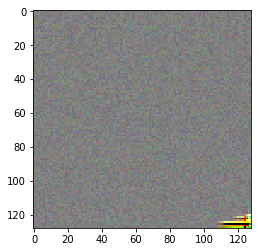

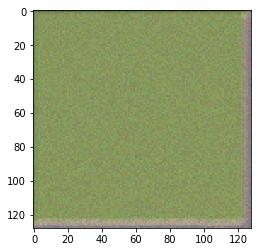

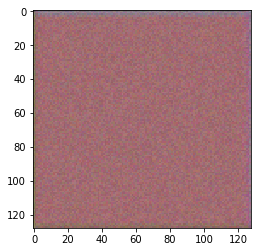

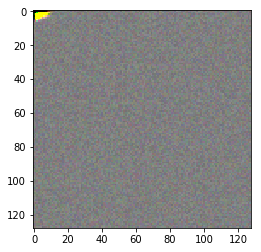

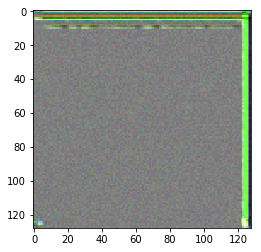

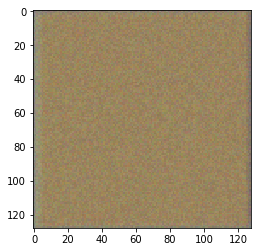

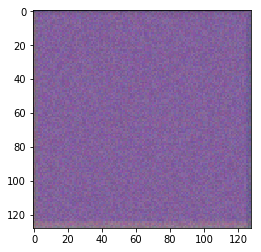

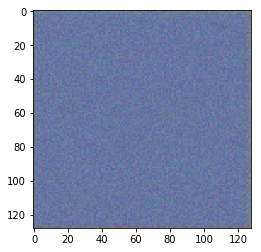

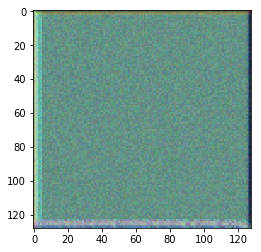

<Figure size 432x288 with 0 Axes>

In [74]:
for filt,loss in kept_filters:
    plt.imshow(filt, )
    plt.show()
    plt.figure()

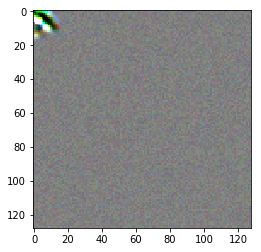

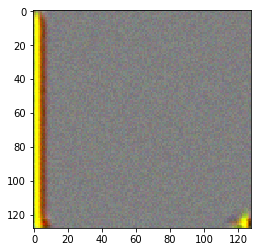

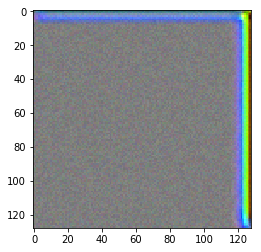

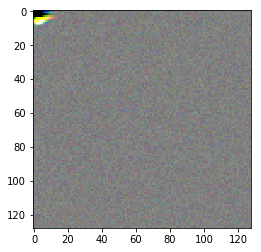

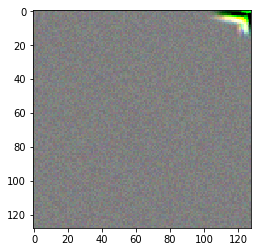

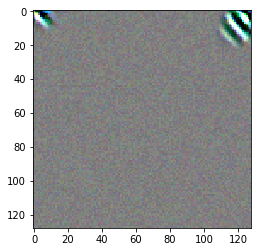

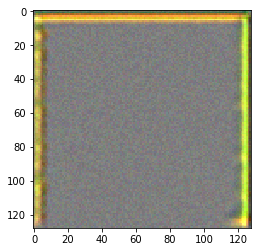

<Figure size 432x288 with 0 Axes>

In [76]:
#second convolutional layer
for filt,loss in kept_filters:
    plt.imshow(filt, )
    plt.show()
    plt.figure()